In [11]:
import numpy as np
import scipy as sp
import corner
import multiprocessing

from iminuit import Minuit

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from mcmc import metropolis_hastings
from plot import plot_2d_pdf_contour

np.random.seed(1)

# 1. MC events and data

In [12]:
M = 125 # GeV

def gen_bkg(N):
    return sp.stats.expon(loc=100, scale=1/0.05).rvs(N)

def gen_sig(N, m=M):
    return sp.stats.norm(loc=m, scale=2).rvs(N)

In [13]:
N_bkg = 100000
N_sig = 1000

mc_bkg = gen_bkg(N_bkg)
mc_sig = gen_sig(N_sig)

bins = np.linspace(100, 160, 50)

bkg_counts, bins = np.histogram(mc_bkg, bins=bins)
sig_counts, bins = np.histogram(mc_sig, bins=bins)


In [14]:
data = np.loadtxt('LHC_data.txt')

data_counts, bins = np.histogram(data, bins=bins)

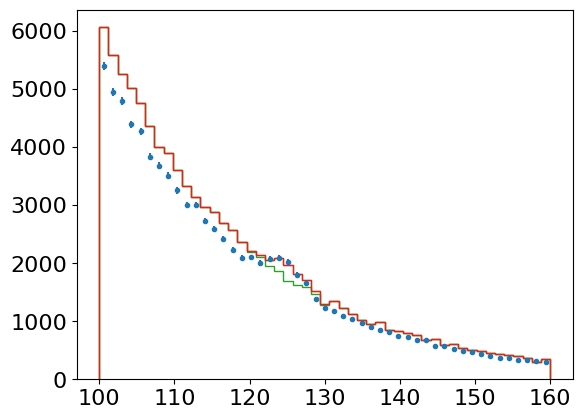

In [15]:
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, data_counts, np.sqrt(data_counts), fmt='.')
plt.stairs(sig_counts+bkg_counts, bins)
plt.stairs(bkg_counts, bins)
plt.stairs(sig_counts+bkg_counts, bins)

# 2. Likelihood function

In [16]:
def negative_log_likelihood(s, b, sig, bkg, data):
    '''
    -2*log(p(data|theta))
    '''
    return -2*np.sum(sp.stats.poisson.logpmf(data, s*sig+b*bkg))

# 3. Priors

We use a flat prior for $\mu$ and a normal prior for $\mu_{bkg}$.

In [17]:
def negative_log_prior(s, b):
    '''
    -2*log(p(theta))
    '''
    ps = 0 if 0 <= s <= 5 else np.inf
    b_exp = 1
    sigma_b = 0.5
    pb = ((b-b_exp)/sigma_b)**2
    return ps+pb

# 4. Posterior

In [27]:
def negative_log_posterior(s, b, sig, bkg, data):
    '''
    -2*log(p(theta|data))
    '''
    return negative_log_likelihood(s, b, sig, bkg, data) + negative_log_prior(s, b)

# 5. Mode and prior impact

In [24]:
nll_unconstrained = lambda s, b: negative_log_likelihood(s, b, sig_counts, bkg_counts, data_counts)

m = Minuit(nll_unconstrained, 1,1, name=(r'$s$', r'$b$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 518.1                      │              Nfcn = 53               │
│ EDM = 2.97e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $s$  │   1.93    │   0.11    │            │            │         │         │       │
│ 1 │ $b$  │  0.9017   │  0.0033   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────┐
│     │       $s$       $b$ │
├─────┼─────────────────────┤
│ $s$ │    0.0119 -0.105e-3 │
│ $b$ │ -0.105e-3  1.06e-05 │
└─────┴─────────────────────┘

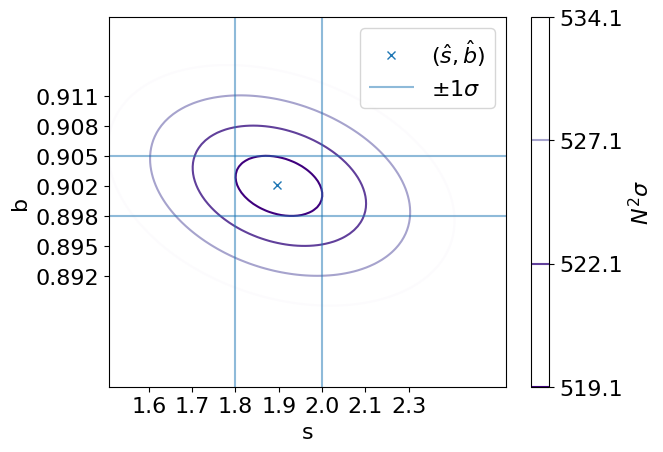

In [26]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nll_unconstrained,
    x_range=(1.5, 2.5),
    y_range=(0.88, 0.92),
    resolution=100,
    x_sigma=sigmax,
    y_sigma=sigmay,
    x_label='s',
    y_label='b',
    mode_label=r'$(\hat s, \hat b)$',
    )

In [28]:
nl_posterior = lambda s, b: negative_log_posterior(s, b, sig_counts, bkg_counts, data_counts)

m = Minuit(nl_posterior, 1,1, name=(r'$s$', r'$b$'))
m.migrad()
m.hesse()

/home/lorenz/presentations/icsc-bayesian-inference/.venv/lib/python3.12/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 518.1                      │              Nfcn = 53               │
│ EDM = 2.97e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $s$  │   1.93    │   0.11    │            │            │         │         │       │
│ 1 │ $b$  │  0.9017   │  0.0033   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────┐
│     │       $s$       $b$ │
├─────┼─────────────────────┤
│ $s$ │    0.0119 -0.105e-3 │
│ $b$ │ -0.105e-3  1.06e-05 │
└─────┴─────────────────────┘

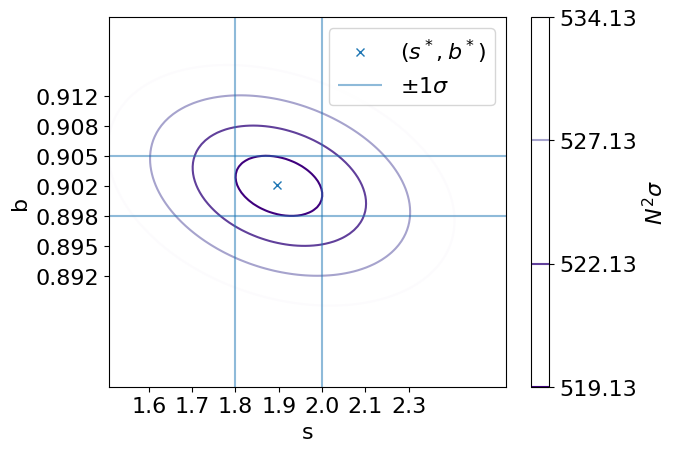

In [30]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nl_posterior,
    x_range=(1.5, 2.5),
    y_range=(0.88, 0.92),
    resolution=100,
    x_sigma=sigmax,
    y_sigma=sigmay,
    x_label='s',
    y_label='b',
    mode_label=r'$(s^*, b^*)$',
    )

# 6. Metropolis hastings

We will copy the implementation from [here](./mcmc.py).

# 7. Posterior samples

We generate samples from the posterior, in independent 8 chains.

In [32]:
iterations = 50000
chains = 8

nlpost = lambda pars: negative_log_posterior(*pars, sig_counts, bkg_counts, data_counts)

# Random initial values for each chain
initial_points = [
    [np.random.uniform(0, 3), np.random.uniform(0, 3)] for _ in range(chains)
]

# Run chains in parallel
def run_chain(initial_point):
    chain = metropolis_hastings(nlpost, iterations, initial_point)
    return chain

with multiprocessing.Pool(processes=chains) as pool:
    chains = pool.map(run_chain, initial_points)

samples = np.vstack(chains)

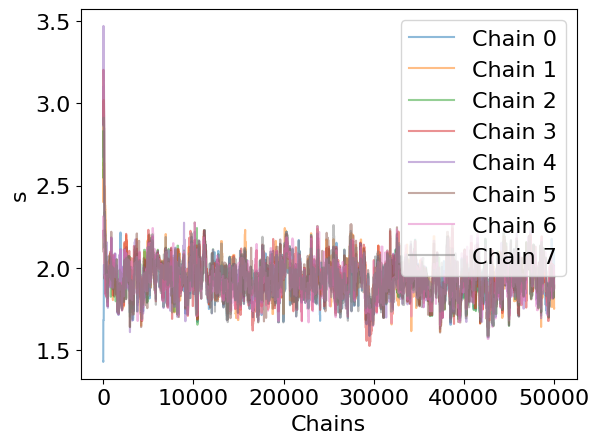

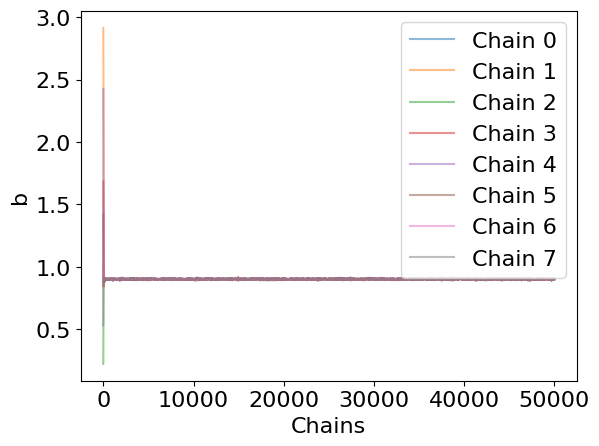

In [41]:
for i,c in enumerate(chains):
    plt.plot(c[:,0], alpha=0.5, label=f'Chain {i}')

plt.xlabel('Chains')
plt.ylabel('s')
plt.legend(loc='upper right')
plt.show()

for i,c in enumerate(chains):
    plt.plot(c[:,1], alpha=0.5, label=f'Chain {i}')

plt.xlabel('Chains')
plt.ylabel('b')
plt.legend(loc='upper right')
plt.show()

# 8. Full and marginal posterior

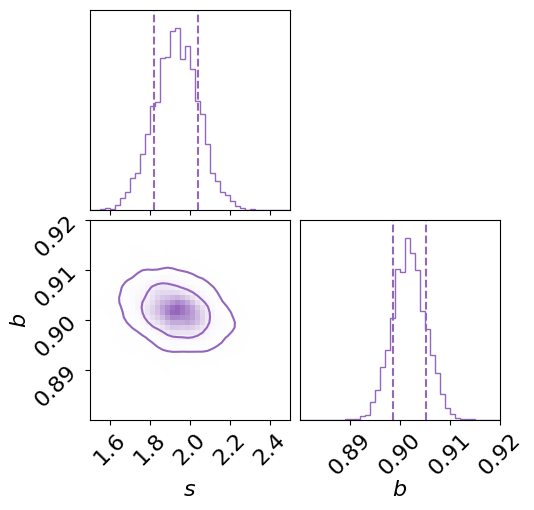

In [42]:
fig = corner.corner(
    samples,
    bins=40,
    range=[(1.5,2.5), (0.88, 0.92)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$s$', r'$b$'],
    color='tab:purple',
    );

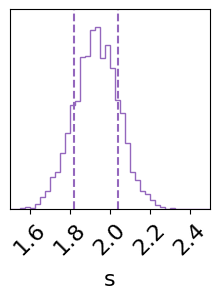

In [43]:
fig = corner.corner(
    samples[:,0],
    bins=40,
    range=[(1.5,2.5)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r's'],
    color='tab:purple',
    );

# 9. Upper 95% credible interval

In [71]:
nsamples = len(samples)

print(f'95% upper CI: {float(np.sort(samples[:,0])[int(0.95*nsamples)])}')

95% upper CI: 2.111560190061554


# 10. Highest density intervals

In [72]:
print(f'68% HDI: {float(np.sort(samples[:,0])[int(0.160*nsamples)]), float(np.sort(samples[:,0])[int(0.840*nsamples)])}')
print(f'95% HDI: {float(np.sort(samples[:,0])[int(0.025*nsamples)]), float(np.sort(samples[:,0])[int(0.975*nsamples)])}')

68% HDI: (1.819073052182413, 2.0416784581076124)
95% HDI: (1.7085889080716483, 2.1531527916111375)


In [73]:
print(f'68% HDI: {float(np.sort(samples[:,1])[int(0.160*nsamples)]), float(np.sort(samples[:,1])[int(0.840*nsamples)])}')
print(f'95% HDI: {float(np.sort(samples[:,1])[int(0.025*nsamples)]), float(np.sort(samples[:,1])[int(0.975*nsamples)])}')

68% HDI: (0.8985185060113862, 0.9052397178615151)
95% HDI: (0.8952945740108861, 0.9084667908501259)
